site sur lequel on peut trouver la météo 
https://www.infoclimat.fr/observations-meteo/archives/27/fevrier/2019/paris-montsouris/07156.html

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
df1 = gpd.read_file("https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
df1 = df1.drop(['url_photos_n1', 'name', 'id', 'channel_id', 'installation_date', 'nom_compteur', 'channel_name'], axis =1)
df1.rename(columns={'id_compteur': 'Identifiant du compteur'}, inplace=True)

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/linogaliana/python-datascientist/master/data/bike.csv", compression = "gzip")
df = df.merge(df1, how = 'left')

In [7]:
df

,Identifiant du compteur,Nom du compteur,Identifiant du site de comptage,Nom du site de comptage,Comptage horaire,Date et heure de comptage,Date d'installation du site de comptage,geometry
0,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,1,2019-08-01T02:00:00Z,2012-02-22,None
1,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,0,2019-08-01T01:00:00Z,2012-02-22,None
2,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,0,2019-08-01T04:00:00Z,2012-02-22,None
3,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,0,2019-08-01T03:00:00Z,2012-02-22,None
4,100003096-SC,97 avenue Denfert Rochereau SO-NE,100003096,97 avenue Denfert Rochereau SO-NE,28,2019-08-01T07:00:00Z,2012-02-22,None
...,...,...,...,...,...,...,...,...
773705,100060175-SC,30 rue Saint Jacques N-S,100060175,30 rue Saint Jacques N-S,5,2020-07-14T03:00:00Z,2020-05-20,POINT (2.34568 48.85113)
773706,100060175-SC,30 rue Saint Jacques N-S,100060175,30 rue Saint Jacques N-S,13,2020-07-14T05:00:00Z,2020-05-20,POINT (2.34568 48.85113)
773707,100060175-SC,30 rue Saint Jacques N-S,100060175,30 rue Saint Jacques N-S,65,2020-07-14T11:00:00Z,2020-05-20,POINT (2.34568 48.85113)
773708,100060175-SC,30 rue Saint Jacques N-S,100060175,30 rue Saint Jacques N-S,142,2020-07-14T14:00:00Z,2020-05-20,POINT (2.34568 48.85113)


In [8]:
la_fayette = df[df['Identifiant du compteur'] == '100003099-SC']

In [9]:
la_fayette

IndexError: too many indices for array

IndexError: too many indices for array

In [10]:
la_fayette['deltah'] = la_fayette['Date et heure de comptage'].str[11:13]
la_fayette['date'] = la_fayette['Date et heure de comptage'].str[:10]
la_fayette['Date en entier'] = pd.to_datetime(la_fayette['Date et heure de comptage'])

C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [11]:
la_fayette = la_fayette.drop(['Identifiant du site de comptage','Identifiant du compteur', 'Nom du compteur', 'Nom du site de comptage', "Date d'installation du site de comptage", "Date et heure de comptage", "Identifiant du site de comptage"], axis = 1)

In [12]:
la_fayette.sort_values('date')

IndexError: too many indices for array

IndexError: too many indices for array

In [4]:
accident_velo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3d5f2317-5afd-4a9f-a9c5-bd4fe0113f39')
accident_velo_idf = accident_velo[accident_velo['departement'].isin(['75','77','78','91','92','93','94','95'])]
# Il y a un problème avec les latitudes et les longitudes nulles et les quelques erreurs

C:\Users\Vinciane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
accident_velo_idf_meteo = accident_velo_idf[['identifiant accident','date','mois', 'jour', 'heure', 'departement','luminosite', 'conditions atmosperiques', 'etat surface', 'sexe', 'age', 'gravite accident', 'commune', ]]
accident_velo_idf_meteo

,identifiant accident,date,mois,jour,heure,departement,luminosite,conditions atmosperiques,etat surface,sexe,age,gravite accident,commune
58,200500001606,2005-01-13,01 - janvier,3 - jeudi,11.0,78,Plein jour,Normale,normale,M,61-62,2 - Blessé hospitalisé,78230
61,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,Plein jour,Normale,normale,M,58-59,0 - Indemne,95042
221,200500004591,2005-01-04,01 - janvier,1 - mardi,17.0,75,Nuit avec éclairage public allumé,Normale,normale,M,36-37,1 - Blessé léger,75001
222,200500004597,2005-01-03,01 - janvier,0 - lundi,9.0,75,Plein jour,Normale,normale,M,26-27,0 - Indemne,75005
223,200500004600,2005-01-03,01 - janvier,0 - lundi,17.0,75,Nuit avec éclairage public allumé,Normale,normale,M,31-32,0 - Indemne,75019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,201800050291,2018-07-10,07 - juillet,1 - mardi,9.0,75,Plein jour,Normale,normale,F,58-59,2 - Blessé hospitalisé,75101
65532,201800050337,2018-11-17,11 - novembre,5 - samedi,12.0,75,Plein jour,Normale,normale,M,59-60,1 - Blessé léger,75101
65533,201800050355,2018-02-01,02 - février,3 - jeudi,15.0,75,Plein jour,Temps couvert,mouillée,M,31-32,1 - Blessé léger,75102
65534,201800050359,2018-02-12,02 - février,0 - lundi,9.0,75,Plein jour,Normale,normale,F,29-30,1 - Blessé léger,75101


In [6]:
accident_velo_idf_meteo.groupby('luminosite')['identifiant accident'].count()

luminosite
Crépuscule ou aube                         825
Nuit avec éclairage public allumé         2717
Nuit avec éclairage public non allumé       66
Nuit sans éclairage public                 206
Plein jour                               13727
Name: identifiant accident, dtype: int64

In [7]:
a = accident_velo_idf_meteo['conditions atmosperiques']

In [8]:
accident_velo_idf_meteo['conditions atmosperiques'] = accident_velo_idf_meteo['conditions atmosperiques'].apply(
    lambda x: "Normale" if x == 'Normale' or x =='Temps éblouissant' or x== 'Autre' else x)
accident_velo_idf_meteo['conditions atmosperiques'] = accident_velo_idf_meteo['conditions atmosperiques'].apply(
    lambda x: "Couvert" if x == 'Brouillard - fumée' or x =='Temps couvert' else x)
accident_velo_idf_meteo['conditions atmosperiques'] = accident_velo_idf_meteo['conditions atmosperiques'].apply(
    lambda x: "Précipitations" if x == 'Pluie forte' or x == 'Pluie légère' or x =='Neige - grêle' or x =='Vent fort - tempête' else x)

C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [9]:
accident_velo_idf_meteo['luminosite'] = accident_velo_idf_meteo['luminosite'].apply(lambda x: "Jour" if x == 'Plein jour' else x)
accident_velo_idf_meteo['luminosite'] = accident_velo_idf_meteo['luminosite'].apply(lambda x: "Nuit" if x == "Crépuscule ou aube" or x == 'Nuit avec éclairage public allumé' or x=='Nuit avec éclairage public non allumé' or x=='Nuit sans éclairage public' else x)

C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
accident_velo_idf_meteo

,identifiant accident,date,mois,jour,heure,departement,luminosite,conditions atmosperiques,etat surface,sexe,age,gravite accident,commune
58,200500001606,2005-01-13,01 - janvier,3 - jeudi,11.0,78,Jour,Normale,normale,M,61-62,2 - Blessé hospitalisé,78230
61,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,Jour,Normale,normale,M,58-59,0 - Indemne,95042
221,200500004591,2005-01-04,01 - janvier,1 - mardi,17.0,75,Nuit,Normale,normale,M,36-37,1 - Blessé léger,75001
222,200500004597,2005-01-03,01 - janvier,0 - lundi,9.0,75,Jour,Normale,normale,M,26-27,0 - Indemne,75005
223,200500004600,2005-01-03,01 - janvier,0 - lundi,17.0,75,Nuit,Normale,normale,M,31-32,0 - Indemne,75019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,201800050291,2018-07-10,07 - juillet,1 - mardi,9.0,75,Jour,Normale,normale,F,58-59,2 - Blessé hospitalisé,75101
65532,201800050337,2018-11-17,11 - novembre,5 - samedi,12.0,75,Jour,Normale,normale,M,59-60,1 - Blessé léger,75101
65533,201800050355,2018-02-01,02 - février,3 - jeudi,15.0,75,Jour,Couvert,mouillée,M,31-32,1 - Blessé léger,75102
65534,201800050359,2018-02-12,02 - février,0 - lundi,9.0,75,Jour,Normale,normale,F,29-30,1 - Blessé léger,75101


In [11]:
accid = accident_velo_idf_meteo.groupby(["luminosite","conditions atmosperiques", ])['identifiant accident'].count()
accid

luminosite  conditions atmosperiques
Jour        Couvert                       495
            Normale                     12162
            Précipitations               1070
Nuit        Couvert                       151
            Normale                      2975
            Précipitations                688
Name: identifiant accident, dtype: int64

In [127]:
accident_velo_idf_meteo[['date','conditions atmosperiques']]
accident_depuis_2012 = accident_velo_idf_meteo.loc[accident_velo_idf_meteo['date'] >= '2018-01-01'][['date','conditions atmosperiques']].sort_values('date')
#meteo_idf_temps_reel = meteo_idf2.loc[meteo_idf2['forecast'] <= DateTime][['forecast', '2_metre_temperature', 'precipitations mm/h' ]].sort_values('forecast').tail(1)
# On fait en rognant l'heure et non en approximant => voir si améliorable ou pas
accident_depuis_2012
#On a 8 000  données depuis 2012

,date,conditions atmosperiques
65275,2018-01-05,Normale
65250,2018-01-05,Normale
65249,2018-01-05,Precipitations
65190,2018-01-06,Normale
65389,2018-01-06,Normale
...,...,...
65247,2018-11-18,Normale
65186,2018-12-13,Normale
65376,2018-12-19,Couvert
65187,2018-12-20,Normale


In [104]:
accident_velo_idf_meteo.sort_values('date')

,identifiant accident,date,mois,jour,heure,departement,luminosite,conditions atmosperiques,etat surface,sexe,age,gravite accident,commune
287,200500006086,2005-01-02,01 - janvier,6 - dimanche,12.0,94,Jour,Normale,NaN,F,26-27,1 - Blessé léger,94043
222,200500004597,2005-01-03,01 - janvier,0 - lundi,9.0,75,Jour,Normale,normale,M,26-27,0 - Indemne,75005
223,200500004600,2005-01-03,01 - janvier,0 - lundi,17.0,75,Nuit,Normale,normale,M,31-32,0 - Indemne,75019
221,200500004591,2005-01-04,01 - janvier,1 - mardi,17.0,75,Nuit,Normale,normale,M,36-37,1 - Blessé léger,75001
224,200500004627,2005-01-05,01 - janvier,2 - mercredi,18.0,75,Nuit,Précipitations,mouillée,M,57-58,1 - Blessé léger,75007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65247,201800036513,2018-11-18,11 - novembre,6 - dimanche,15.0,91,Jour,Normale,normale,M,14-15,2 - Blessé hospitalisé,91103
65186,201800034269,2018-12-13,12 - décembre,3 - jeudi,14.0,77,Jour,Normale,normale,M,64-65,1 - Blessé léger,77464
65376,201800040459,2018-12-19,12 - décembre,2 - mercredi,19.0,93,Nuit,Couvert,mouillée,F,5-6,1 - Blessé léger,93050
65187,201800034384,2018-12-20,12 - décembre,3 - jeudi,13.0,77,Jour,Normale,normale,M,13-14,1 - Blessé léger,77122


D'après ce site, on a  https://www.iau-idf.fr/fileadmin/NewEtudes/Etude_1120/40ansEvolutionVelo.pdf

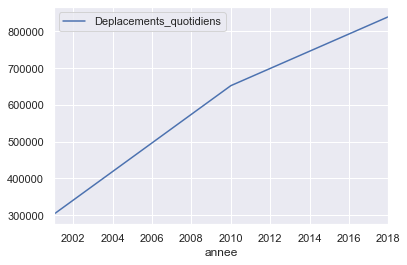

In [126]:
annee =[2001, 2010, 2018]
Deplacements_quotidiens= [302219, 652496,840000]
d = {'annee': annee, 'Deplacements_quotidiens': Deplacements_quotidiens}
df = pd.DataFrame(data=d)
df.plot('annee')
#Rajouter titre

In [145]:
from datetime import date
l = []
for i in range (2005,2018):
    d0 = date(i, 1, 1)
    d1 = date(i+1,12, 31)
    delta = d1 - d0
    nb_deplacement_an = delta.days*np.interp(i, x, y)
    l.append(nb_deplacement_an)
nb_deplacement_total = sum(l) #Nombre  total de trajet parcourus
nb_deplacement_total

6240583002.666666

In [149]:
accident_velo_idf_meteo['identifiant accident'].count()

17541

In [150]:
#Nombre d'accident par rapport au total des déplacements entre 2005 et 2018
#Fréquence d'un accident
accident_velo_idf_meteo['identifiant accident'].count()/nb_deplacement_total 


2.8107950799636104e-06

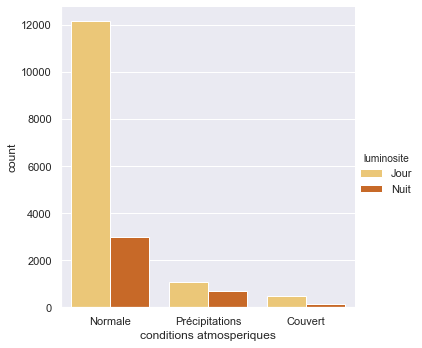

In [151]:
sns.catplot(x="conditions atmosperiques", hue = 'luminosite', kind="count", palette="YlOrBr", data=accident_velo_idf_meteo)


## Faire une régression linéaire avec nos données